In [4]:
# https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb
!pip install darts

  Using cached darts-0.30.0-py3-none-any.whl.metadata (52 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-many

In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

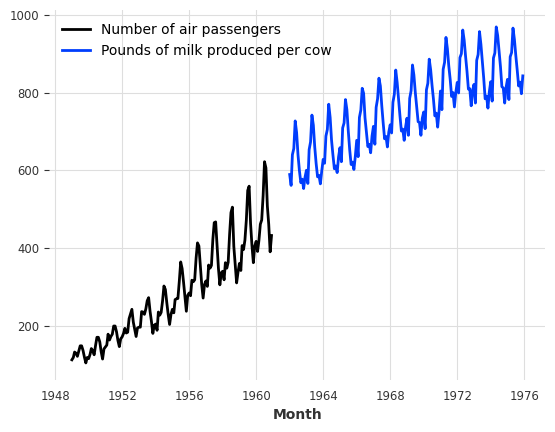

In [7]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

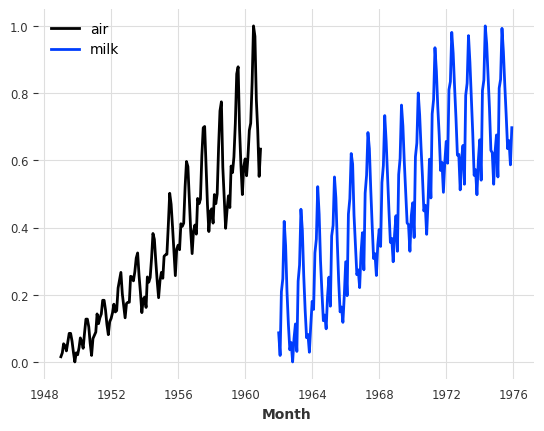

In [8]:
# normalize
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend()

In [9]:
# train validation split
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

In [10]:
# model
model_air = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=200,
    random_state=0,
    **generate_torch_kwargs()
)

In [11]:
model_air.fit(train_air)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=200, random_state=0, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7b354f8b51b0>]})

MAPE = 8.02%


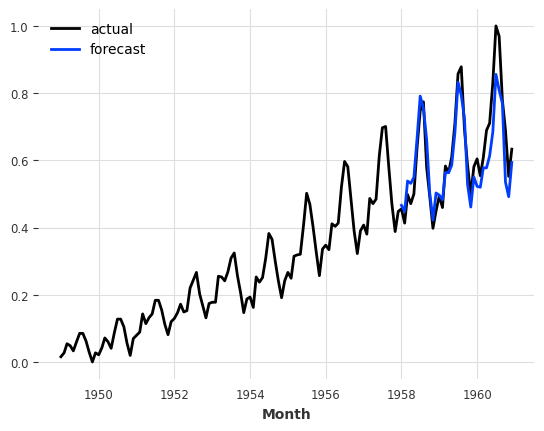

In [12]:
pred = model_air.predict(n=36)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

In [13]:
# Training on Both Air Traffic and Milk Series
model_air_milk = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    random_state=0,
    **generate_torch_kwargs()
)

In [14]:
model_air_milk.fit([train_air, train_milk])

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7b3551db8a90>]})

MAPE = 7.16%


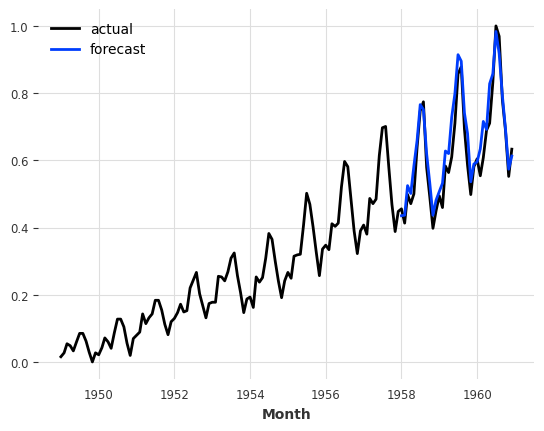

In [15]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

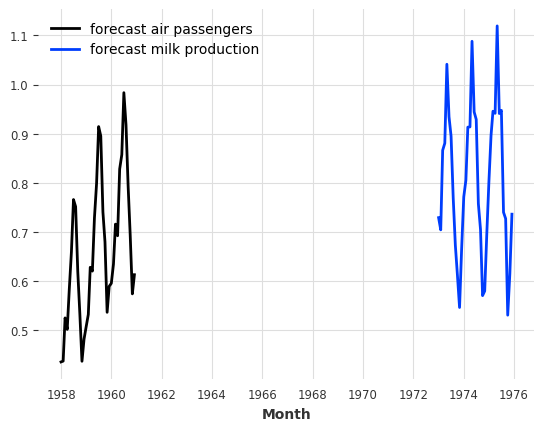

In [16]:
# show predictions separately
pred_list = model_air_milk.predict(n=36, series=[train_air, train_milk])
for series, label in zip(pred_list, ["air passengers", "milk production"]):
    series.plot(label=f"forecast {label}")
plt.legend()

Text(0.5, 1.0, 'Milk production covariates (year and month)')

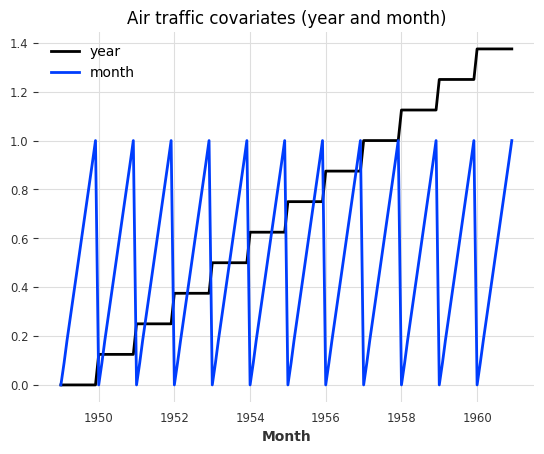

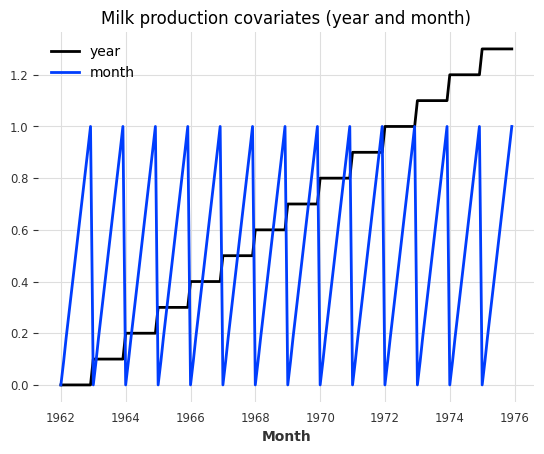

In [17]:
# Covariates Series
# build year and month series:
air_year = datetime_attribute_timeseries(series_air_scaled, attribute="year")
air_month = datetime_attribute_timeseries(series_air_scaled, attribute="month")

milk_year = datetime_attribute_timeseries(series_milk_scaled, attribute="year")
milk_month = datetime_attribute_timeseries(series_milk_scaled, attribute="month")

# stack year and month to obtain series of 2 dimensions (year and month):
air_covariates = air_year.stack(air_month)
milk_covariates = milk_year.stack(milk_month)

# split in train/validation sets:
air_train_covariates, air_val_covariates = air_covariates[:-36], air_covariates[-36:]
milk_train_covariates, milk_val_covariates = (
    milk_covariates[:-36],
    milk_covariates[-36:],
)

# scale them between 0 and 1:
scaler_covariates = Scaler()
air_train_covariates, milk_train_covariates = scaler_covariates.fit_transform(
    [air_train_covariates, milk_train_covariates]
)
air_val_covariates, milk_val_covariates = scaler_covariates.transform(
    [air_val_covariates, milk_val_covariates]
)

# concatenate for the full scaled series; we can feed this to model.fit()/predict() as Darts will extract the required covariates for you
air_covariates = concatenate([air_train_covariates, air_val_covariates])
milk_covariates = concatenate([milk_train_covariates, milk_val_covariates])

# plot the covariates:
plt.figure()
air_covariates.plot()
plt.title("Air traffic covariates (year and month)")

plt.figure()
milk_covariates.plot()
plt.title("Milk production covariates (year and month)")

In [18]:
# model covariates
model_name = "BlockRNN_test"
model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    random_state=0,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    **generate_torch_kwargs()
)

In [19]:
model_pastcov.fit(
    series=[train_air, train_milk],
    past_covariates=[air_covariates, milk_covariates],
    val_series=[val_air, val_milk],
    val_past_covariates=[air_covariates, milk_covariates],
)

Training: 0it [00:00, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, model_name=BlockRNN_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7b36633f2e30>]})

In [20]:
model_pastcov = BlockRNNModel.load_from_checkpoint(model_name=model_name, best=True)

In [21]:
# using future covariate
model_name = "RNN_test"
model_futcov = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=0,
    training_length=35,
    input_chunk_length=24,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    **generate_torch_kwargs()
)

model_futcov.fit(
    series=[train_air, train_milk],
    future_covariates=[air_covariates, milk_covariates],
    val_series=[val_air, val_milk],
    val_future_covariates=[air_covariates, milk_covariates],
)

Training: 0it [00:00, ?it/s]

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=35, batch_size=8, n_epochs=100, random_state=0, input_chunk_length=24, model_name=RNN_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7b354e808be0>]})

In [22]:
model_futurecov = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

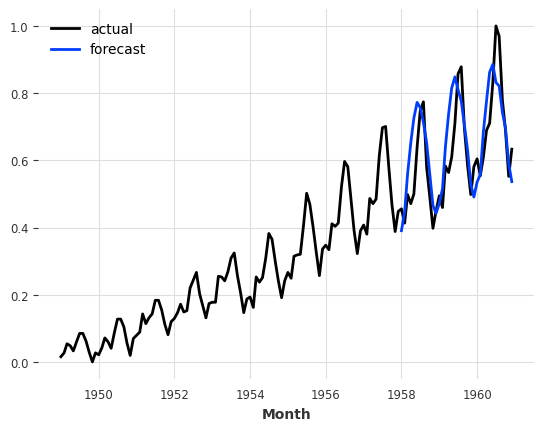

In [23]:
# prediction using past covariates
pred_cov = model_pastcov.predict(n=36, series=train_air, past_covariates=air_covariates)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()

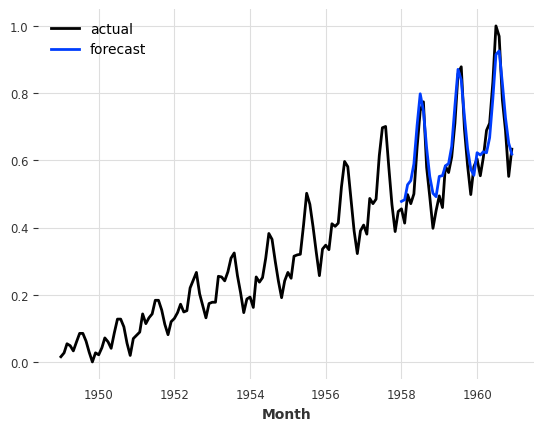

In [24]:
# prediction using future covariates
pred_cov = model_futcov.predict(
    n=36, series=train_air, future_covariates=air_covariates
)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()

In [25]:
# backtest model
backtest_pastcov = model_pastcov.historical_forecasts(
    series_air_scaled,
    past_covariates=air_covariates,
    start=val_air.start_time(),
    forecast_horizon=12,
    stride=12,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
backtest_pastcov = concatenate(backtest_pastcov)
print(
    "MAPE (BlockRNNModel with past covariates) = {:.2f}%".format(
        mape(series_air_scaled, backtest_pastcov)
    )
)

backtest_futcov = model_futcov.historical_forecasts(
    series_air_scaled,
    future_covariates=air_covariates,
    start=val_air.start_time(),
    forecast_horizon=12,
    stride=12,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
backtest_futcov = concatenate(backtest_futcov)
print(
    "MAPE (RNNModel with future covariates) = {:.2f}%".format(
        mape(series_air_scaled, backtest_futcov)
    )
)

MAPE (BlockRNNModel with past covariates) = 12.09%
MAPE (RNNModel with future covariates) = 10.26%


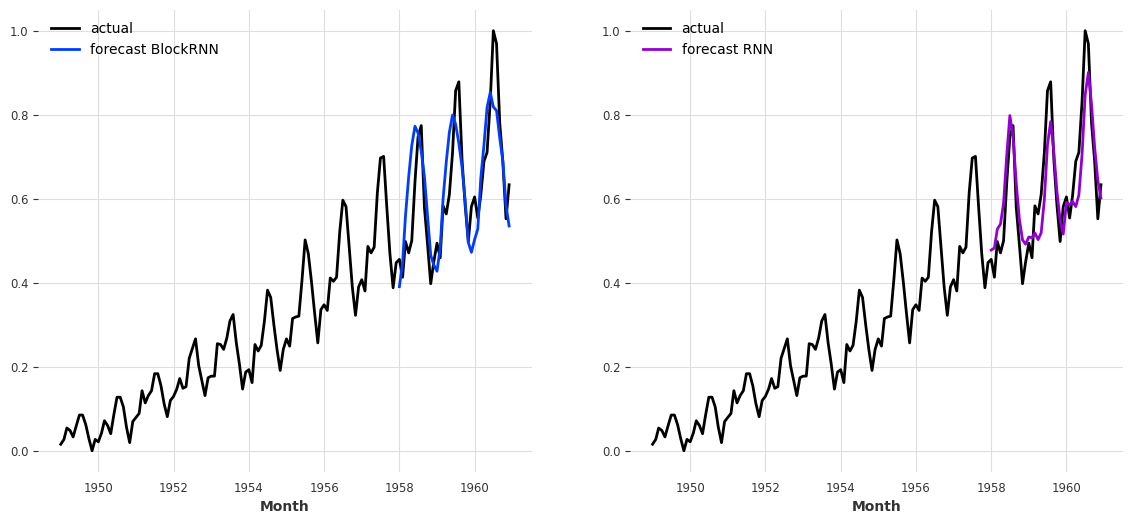

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
series_air_scaled.plot(label="actual", ax=axs[0])
backtest_pastcov.plot(label="forecast BlockRNN", ax=axs[0])
axs[0].legend()
series_air_scaled.plot(label="actual", ax=axs[1])
backtest_futcov.plot(label="forecast RNN", ax=axs[1], color="darkviolet")
axs[1].legend()
plt.show()

In [28]:
# more than two variables
multi_serie_elec = ElectricityDataset().load()

In [29]:
# retaining only three components in different ranges
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]
# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="1H")
# keep the values for the last 5 days
multi_serie_elec = multi_serie_elec[-168:]

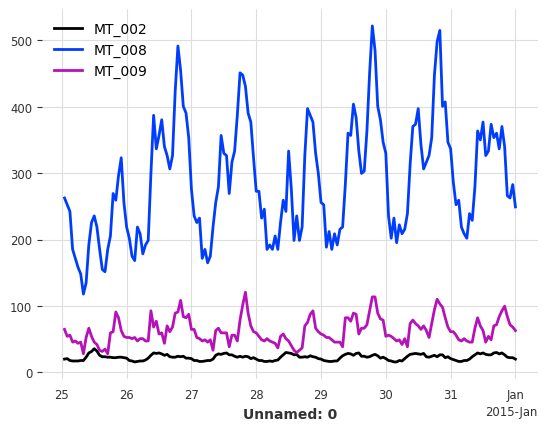

In [30]:
multi_serie_elec.plot()
plt.show()

In [31]:
# split in train/validation sets
training_set, validation_set = multi_serie_elec[:-24], multi_serie_elec[-24:]

# define a scaler, by default, normalize each component between 0 and 1
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(training_set)
validation_scaled = scaler_dataset.transform(validation_set)


def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [32]:
model_VARIMA = VARIMA(p=12, d=0, q=0, trend="n")

model_GRU = RNNModel(
    input_chunk_length=24,
    model="LSTM",
    hidden_dim=25,
    n_rnn_layers=3,
    training_length=36,
    n_epochs=200,
    **generate_torch_kwargs()
)

# training and prediction with the VARIMA model
forecast_VARIMA = fit_and_pred(model_VARIMA, training_scaled, validation_scaled)
print("MAE (VARIMA) = {:.2f}".format(mae(validation_scaled, forecast_VARIMA)))

# training and prediction with the RNN model
forecast_RNN = fit_and_pred(model_GRU, training_scaled, validation_scaled)
print("MAE (RNN) = {:.2f}".format(mae(validation_scaled, forecast_RNN)))

MAE (VARIMA) = 0.11


Training: 0it [00:00, ?it/s]

MAE (RNN) = 0.10


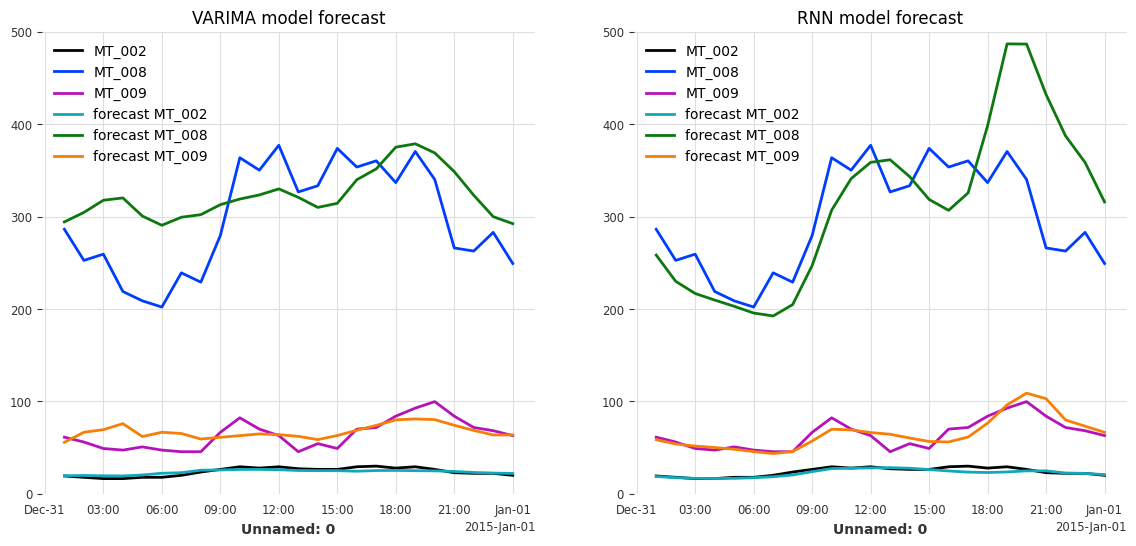

In [33]:
forecast_VARIMA = scaler_dataset.inverse_transform(forecast_VARIMA)
forecast_RNN = scaler_dataset.inverse_transform(forecast_RNN)

labels = [f"forecast {component}" for component in retained_components]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
validation_set.plot(ax=axs[0])
forecast_VARIMA.plot(label=labels, ax=axs[0])
axs[0].set_ylim(0, 500)
axs[0].set_title("VARIMA model forecast")
axs[0].legend(loc="upper left")
validation_set.plot(ax=axs[1])
forecast_RNN.plot(label=labels, ax=axs[1])
axs[1].set_ylim(0, 500)
axs[1].set_title("RNN model forecast")
axs[1].legend(loc="upper left")
plt.show()